In [1]:
from m8r import view

In [6]:
%%file 1_train.scons 


import sys
import numpy as np

import os
# fixes wierd Mac problem
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

import torch
torch.manual_seed(2021) # for reproducibility

import m8r

from torchvision import datasets, transforms

def get_data(target=None,source=None,env=None):
    # emits data subdirectory - clean later
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    train_data = datasets.MNIST('./data', train=True, 
                            download=True,
                            transform=transform)
    test_data = datasets.MNIST('./data', train=False,
                             download=True,
                            transform=transform)
    m8r.File(train_data.data.numpy(),name=str(target[0]))
    m8r.File(train_data.targets.numpy(),name=str(target[1]))
    m8r.File(test_data.data.numpy(),name=str(target[2]))
    m8r.File(test_data.targets.numpy(),name=str(target[3]))
    
Command(['xtrain.rsf','ytrain.rsf','xtest.rsf','ytest.rsf'],None,
       action=Action(get_data))

examples = []
for example in (10010,20010,30010,40010,50010):
    label = 'label%d.txt' % example
    Flow(label,'ytrain',
         '''
         window n1=1 f1=%d | disfil format='title=label:%%d' number=n
         ''' % example)
    xtrain = 'xtrain%d' % example
    Plot(xtrain,['xtrain',label],
         '''
         window n3=1 f3=%d | 
         grey par=${SOURCES[1]} screenratio=1 transp=n wantaxis=n color=I titlesz=24
         ''' % example)
    examples.append(xtrain)
    
Result('train',examples,'SideBySideIso')

Writing 1_train.scons


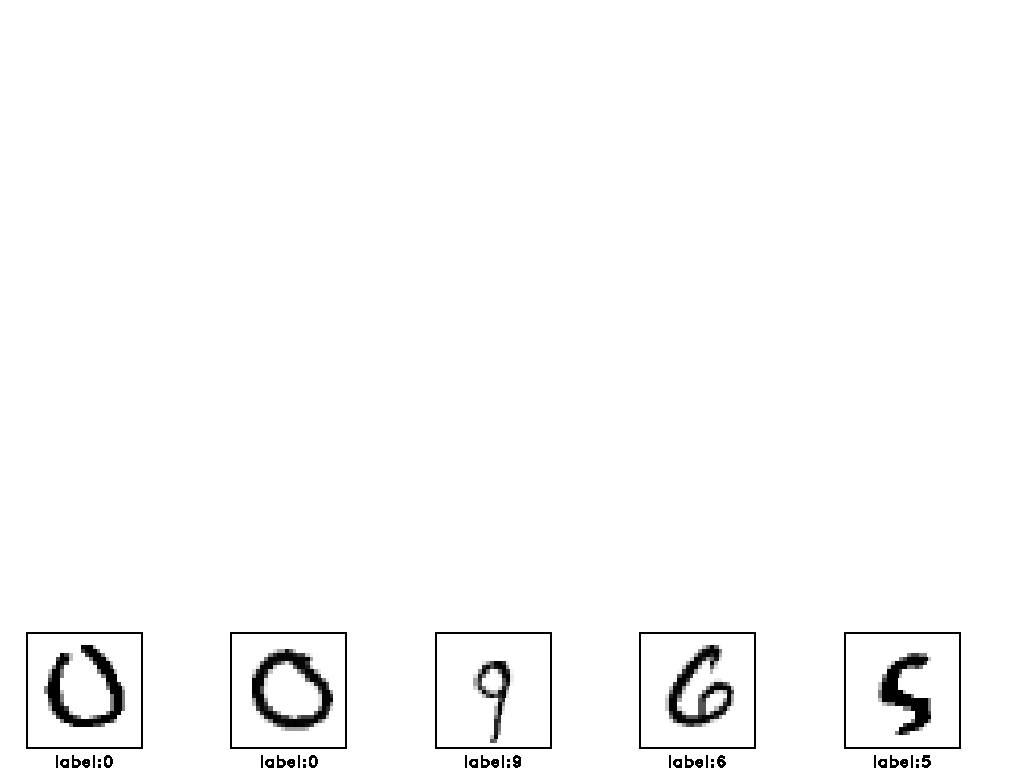

In [7]:
view("train")

In [18]:
%%file 2_test.scons 


import torch.nn as nn
import torch.nn.functional as F

# design neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)

def train(train_loader,epoch):
    global model,device,optimizer
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    global model,device
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
            
from torch.utils.data import TensorDataset, DataLoader

def train_model(target=None,source=None,env=None):
    global model,device,optimizer
    
    x_train = torch.from_numpy(m8r.File(str(source[0]))[:])
    y_train = torch.from_numpy(m8r.File(str(source[1]))[:])
    x_test = torch.from_numpy(m8r.File(str(source[2]))[:])
    y_test = torch.from_numpy(m8r.File(str(source[3]))[:])

    batch_size=env.get('batch_size')
    epochs=env.get('epochs')

    x_train = x_train.unsqueeze(1)
    train_data = TensorDataset(x_train.float(),y_train.long())
    train_loader = DataLoader(train_data,batch_size=batch_size)

    x_test = x_test.unsqueeze(1)
    test_data = TensorDataset(x_test.float(),y_test.long())
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=1000)

    from torch.optim.lr_scheduler import StepLR

    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    for epoch in range(1,epochs+1):
        train(train_loader,epoch)
        test(test_loader)
        scheduler.step()

    # save model
    torch.save(model.state_dict(),str(target[0]))
        
Command('model.pt',['xtrain.rsf','ytrain.rsf','xtest.rsf','ytest.rsf'],
        action=Action(train_model),
        varlist=['batch_size','epochs'],batch_size=64,epochs=15)

def predict(target=None,source=None,env=None):
    global model
    model.load_state_dict(torch.load(str(source[0])))
    model.eval()

    x_test = torch.from_numpy(m8r.File(str(source[1]))[:])
    x_test = x_test.unsqueeze(1).float().to(device)
    y_pred = model(x_test).detach().to('cpu')
    m8r.File(y_pred.numpy(),name=str(target[0]))
    
Command('ypred.rsf',['model.pt','xtest.rsf'],action=Action(predict))

examples = []
for example in (110,210,310,410,510):
    label = 'plabel%d.txt' % example
    Flow(label,'ypred',
         '''
         window n2=1 f2=%d | attr want=max | awk \'{ printf(\"title=label:%%d\n\",$$NF-1)}\'
         ''' % example)
    xtest = 'xtest%d' % example
    Plot(xtest,['xtest',label],
         '''
         window n3=1 f3=%d | 
         grey par=${SOURCES[1]} screenratio=1 transp=n wantaxis=n color=I titlesz=24
         ''' % example)
    examples.append(xtest)
    
Result('test',examples,'SideBySideIso')

Overwriting 2_test.scons


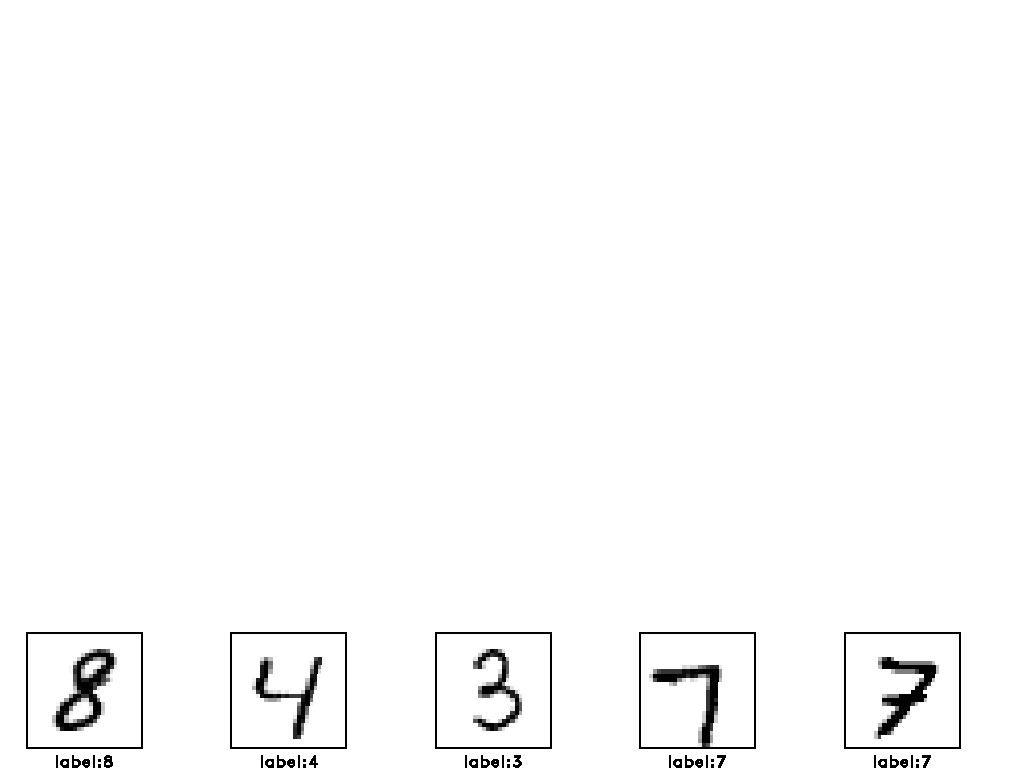

In [19]:
view("test")